# Advanced Lane Finding Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images. Apply a distortion correction to raw images.
2. Use color transforms, gradients, etc., to create a thresholded binary image.
3. Apply a perspective transform to rectify binary image ("birds-eye view").
4. Detect lane pixels and fit to find the lane boundary.
5. Warp the detected lane boundaries back onto the original image.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [9]:
import numpy as np
import cv2
import matplotlib.image as mpimg

import glob
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

print('...')

...


# Step 1-> Calibrate the camera
I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image. Thus, objp is just a replicated array of coordinates, and objpoints will be appended with a copy of it every time I successfully detect all chessboard corners in a test image. imgpoints will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.

I then used the output objpoints and imgpoints to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function. 

In [89]:
def calibrateCamera(images):
    objpoints=[]
    imgpoints=[]   
    objp=np.zeros((6*9,3),np.float32)
    objp[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)    
    for fname in images:
        img=mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        if ret==True:
            imgpoints.append(corners)
            objpoints.append(objp)    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

In [ ]:
#Calibrate
imagesForCalibration=glob.glob('/Volumes/Shubhra/Study/Udacity/AdvancedLaneFinding/CarND-Advanced-Lane-Lines-master/camera_cal/*.jpg')
mtx,dist = calibrateCamera(imagesForCalibration)

#### Undistort Test Image
I applied this distortion correction coefficients to the test image using the cv2.undistort() function and obtained this result:

...


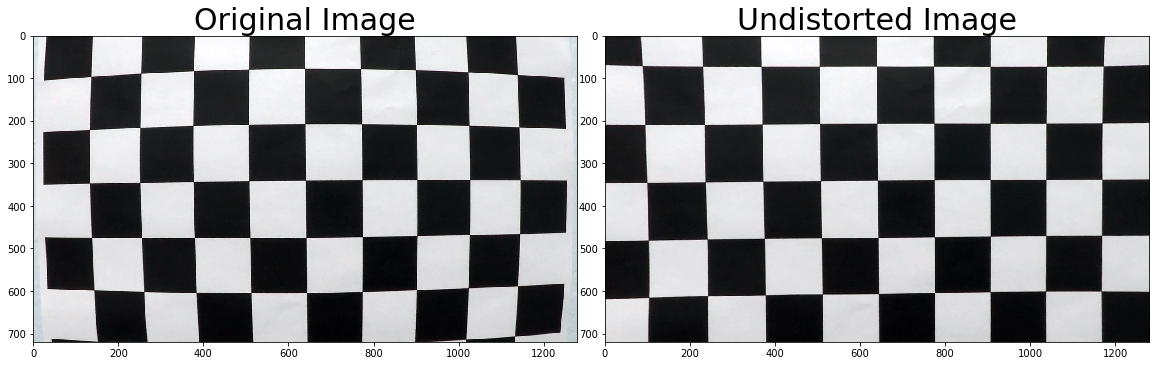

In [12]:
img = cv2.imread('/Volumes/Shubhra/Study/Udacity/AdvancedLaneFinding/CarND-Advanced-Lane-Lines-master/camera_cal/calibration1.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
print('...')

...


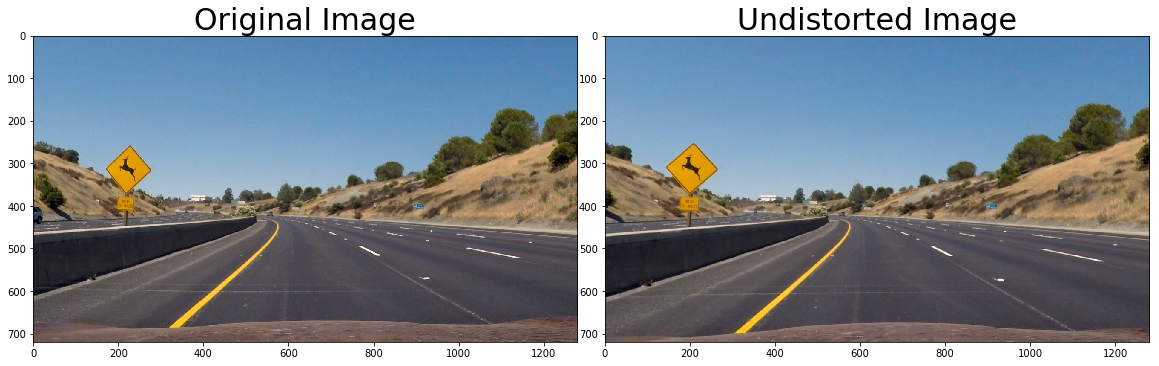

In [68]:
img = mpimg.imread('/Volumes/Shubhra/Study/Udacity/AdvancedLaneFinding/CarND-Advanced-Lane-Lines-master/test_images/test2.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
print('...')

# Step 2 -> Color and Gradient Threshold

I used a combination of x gradient threshold and color threshold on s channel.
I played with various combinations of color, gradient(x and y) thresholds and this is what worked well.

In [69]:
s_thresh=(170, 255)#(33,130)#(170, 255)
sx_thresh=(20, 100)
#img = np.copy(img)
# Convert to HLS color space and separate the V channel
hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS).astype(np.float)
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]
# Sobel x
sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

# Threshold color channel
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
# Stack each channel
# Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
# be beneficial to replace this channel with something else.
#color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

Here is how the binary image looks like after the color and gradient thresholding

...


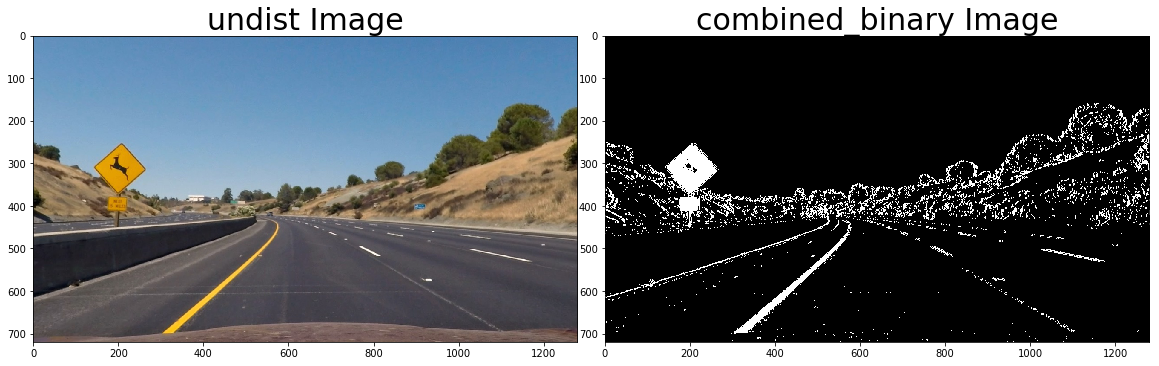

In [90]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(undist)
ax1.set_title('undist Image', fontsize=30)
ax2.imshow(combined_binary,cmap='gray')
ax2.set_title('combined_binary Image', fontsize=30)
print('...')

# Step 3 -> Apply a perspective transform to rectify binary image

I picked four points in a trapezoidal shape that would represent a rectangle when looking down on the road from above. I define the source and destination points and calculate the M and Minv that will be used to transform image from the front view system to the top view.

In [91]:
#Perspective Transform
src = np.array([[270, 670],[550,480],[735,480],[1035,670]],np.float32)
dst=np.array([[270, 710],[270,50],[1035,50],[1035,710]],np.float32)
M = cv2.getPerspectiveTransform(src, dst)
Minv=cv2.getPerspectiveTransform(dst, src)


In [92]:
img_size= (combined_binary.shape[1],combined_binary.shape[0])
binary_warped = cv2.warpPerspective(combined_binary, M, img_size , flags=cv2.INTER_LINEAR)

### Here is how the top view of the binary image looks like.

...


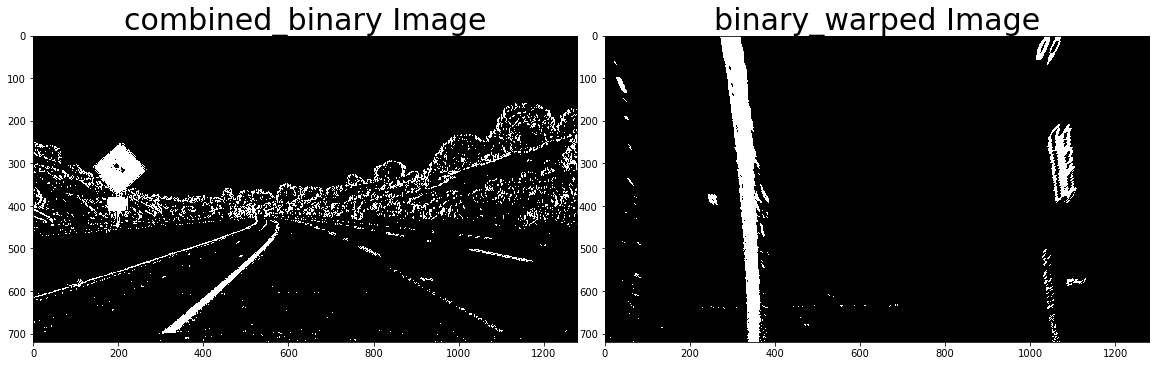

In [94]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(combined_binary,cmap='gray')
ax1.set_title('combined_binary Image', fontsize=30)
ax2.imshow(binary_warped,cmap='gray')
ax2.set_title('binary_warped Image', fontsize=30)
print('...')

# Create a pipeline of steps 1,2,3 so that we could do these through a function

In [95]:
def pipeline(img,mtx, dist):
    s_thresh=(170, 255)#(33,130)#(170, 255)
    sx_thresh=(20, 100)
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    img_size= (combined_binary.shape[1],combined_binary.shape[0])
    binary_warped = cv2.warpPerspective(combined_binary, M, img_size , flags=cv2.INTER_LINEAR)
    return binary_warped

### Here is how the test images perform with the pipeline

...


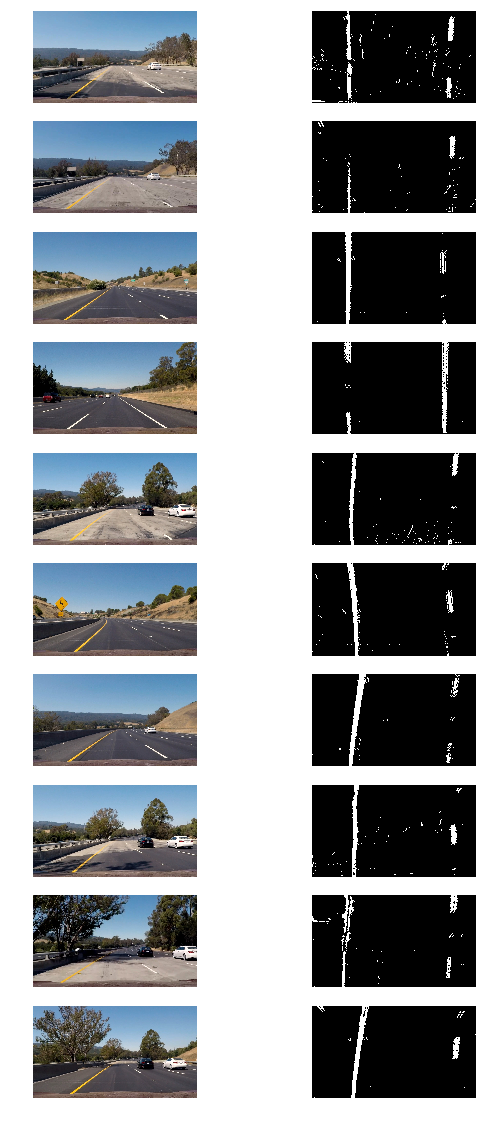

In [96]:
# Make a list of example images
images = glob.glob('/Volumes/Shubhra/Study/Udacity/AdvancedLaneFinding/CarND-Advanced-Lane-Lines-master/test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin = pipeline(img,mtx,dist)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1

print('...')

# Step 4 -> Detect lane pixels and fit to find the lane boundary.

After applying calibration, thresholding, and a perspective transform to a road image, we have a binary image where the lane lines stand out clearly. I use the histogram method as in the function below to figure out the lane line fits. 

When doing the lane detection on the video, we need to apply the histogram method for the first image necessarily.In the next frame of video we don't need to do a blind search again, but instead we can just search in a margin around the previous line position as in the function polyfitUsingPrevFit below



In [97]:
def slidingWindowPolyfit(binary_warped):
    #sliding windows for 1st image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 10#9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80#100
    # Set minimum number of pixels found to recenter window
    minpix =40# 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit,right_fit,left_lane_inds,right_lane_inds

def polyfitUsingPrevFit(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80#100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
  
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

In [98]:
l_fit, r_fit, l_lane_inds, r_lane_inds = slidingWindowPolyfit(binary_warped)
print(l_fit)
print(r_fit)

[ -1.21343775e-04   1.62459498e-01   2.94170948e+02]
[ -2.74915328e-04   2.11511339e-01   1.03438279e+03]


# Step 5-> Warp the detected lane boundaries back onto the original image.

In [99]:
def paintLane(testimg,binary_warped, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(testimg, 1, newwarp, 0.3, 0)
    return result

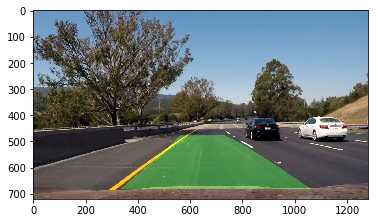

In [100]:
paintedLane = paintLane(img,binary_warped, l_fit, r_fit)

plt.imshow(paintedLane)


# Step 6-> Determine the curvature of the lane and vehicle position with respect to center.

In [101]:
def findCurvature(binary_warped,left_fit, right_fit,l_lane_inds, r_lane_inds):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ploty = np.linspace(0, binary_warped.shape[0], binary_warped.shape[0] )
    y_eval = np.max(ploty)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
   
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty   *ym_per_pix, leftx  * xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty *ym_per_pix, rightx * xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        #print(left_curverad, 'm', right_curverad, 'm')
       
    if left_fit is not None and right_fit is not None:
        car_pos = binary_warped.shape[1]/2
        bottom_x = binary_warped.shape[0]
        left_lane_fit_col_int  = left_fit[0]*bottom_x**2  + left_fit[1]*bottom_x + left_fit[2]
        right_lane_fit_col_int = right_fit[0]*bottom_x**2 + right_fit[1]*bottom_x + right_fit[2]
       
        lane_center = (left_lane_fit_col_int + right_lane_fit_col_int)/2
        center_dist = (car_pos- lane_center) * xm_per_pix;
       
        #print("center-distance", center_dist)
       
    return left_curverad, right_curverad, center_dist

def addTexttoImg(img, left_curverad, right_curverad, center_dist):
    rad=(left_curverad+right_curverad)/2
    message1 = "Radius of Curvature : " + str(format(rad, '.2f'))+' m'
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    message2 = "Center Distance: "+ str(format(abs_center_dist, '.2f'))+ 'm ' + direction + ' of center'

    img = cv2.putText(img, message1, (50,50), thickness=2,fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale =1, color = (0,255,0))
    img = cv2.putText(img, message2, (50,80), thickness=2,fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale =1, color = (0,255,0))
    return img

...


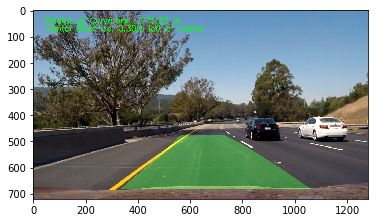

In [102]:
left_curverad, right_curverad, center_dist = findCurvature(binary_warped, l_fit, r_fit, l_lane_inds, r_lane_inds)
result = addTexttoImg(paintedLane,left_curverad, right_curverad, center_dist)

plt.imshow(result)
print('...')

# Lane Detection on video

When doing the lane detection on the video, we will follow the steps below:
1. Run every fram through pipeline so we have binary warped images.
2. To find the left and right line fits, we first need to apply the histogram method for the first image necessarily.In the next frame of video we don't need to do a blind search again, but instead we can just search in a margin around the previous line position as in the function polyfitUsingPrevFit above.
3. To smoothen out the line fits from one frame to the next, I save the characteristics for left and right separately as in the Line class below upto a maximum of n last readings. Best fit characteristic is calculated from these most recent readings. For any frame where there weren't sufficient data points and hence polyfitUsingPrevFit didn't return any line fit characteristics, nothing will be updated to the class.At all frames, we will just update the best fit characteristics and use those.

This approach worked out very well for the project video.

In [104]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
        
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # Not a great fit, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

### processImage lambda function to that runs through entire pipeline and saves the painted lanes image for every frame

In [105]:
def process_image(img):
    new_img = np.copy(img)
    binary_warped=pipeline(img,mtx, dist)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds = slidingWindowPolyfit(binary_warped)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfitUsingPrevFit(binary_warped, l_line.best_fit, r_line.best_fit)
                    
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    if l_line.best_fit is not None and r_line.best_fit is not None:
        result1 = paintLane(img,binary_warped, l_line.best_fit, r_line.best_fit)
        left_curverad, right_curverad, center_dist = findCurvature(binary_warped, l_line.best_fit, r_line.best_fit, l_lane_inds, r_lane_inds)
        result = addTexttoImg(result1,left_curverad, right_curverad, center_dist)
    else:
        result=new_img
    return result

In [106]:

l_line = Line()
r_line = Line()

clip1 = VideoFileClip("/Volumes/Shubhra/Study/Udacity/AdvancedLaneFinding/CarND-Advanced-Lane-Lines-master/project_video.mp4")#.subclip(0,3)
white_clip = clip1.fl_image(process_image)
white_output = '/Volumes/Shubhra/Study/Udacity/AdvancedLaneFinding/CarND-Advanced-Lane-Lines-master/project_video_alloutputFinal.mp4'
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video /Volumes/Shubhra/Study/Udacity/AdvancedLaneFinding/CarND-Advanced-Lane-Lines-master/project_video_alloutputFinal.mp4
[MoviePy] Writing video /Volumes/Shubhra/Study/Udacity/AdvancedLaneFinding/CarND-Advanced-Lane-Lines-master/project_video_alloutputFinal.mp4


100%|█████████▉| 1260/1261 [02:08<00:00,  9.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /Volumes/Shubhra/Study/Udacity/AdvancedLaneFinding/CarND-Advanced-Lane-Lines-master/project_video_alloutputFinal.mp4 



# Discussion 

The image processing pipeline that was established to find the lane lines in images successfully processes the video. Check out the attached output file, the lanes are identified in every frame, and outputs are generated regarding the radius of curvature of the lane and vehicle position within the lane. The pipeline seems to correctly map out curved lines and appears very smooth. It does not fail when shadows or pavement color changes are present. 

In regions of shadow or inappropriate contrast/color conditions, its a bit wobbly probably because there weren't sufficient data points detected

Radius of curvature estimated looks good and so is the position of car wrt the lane.

Code : AdvLaneFinding.py
Output video: project_video_output

##### Performance on challenge video:
The code didn't seem to do very well on challenge video owing to light, shadow and color conditions. Might need to experiment with other sobel threshold conditions to make that work